# Gelman's bioassay using Gibbs sampler

I found this example in "Bayesian Data Analysis" by A. Gelman, J.B. Carlin, H.S. Stern, D.B. Dunson, A.Vehtari and D.B. Rubin.  Here is my translation into python.

This is a good example for a two-dimensional problem (2 parameters) that can be solved by drawing from the inverse of the cummulative distribution functions.

The Bioassay example is about evaluating LD50 tests. The drug dose is logarithmic.

In [26]:
import numpy as np
from scipy import integrate
from scipy import interpolate
import matplotlib.pylab as plt
%matplotlib inline

In [27]:
# Samples for each dose level
n_samples = 5 * np.ones(4, dtype=int)
# Log-dose
dose = np.array([-.86, -.3, -.05, .73])
deaths=np.array([0, 1, 3, 5])

p_posterior is proportional to the posterior probability of alpha and beta given the observed data.  The model is that $logit(\theta)=\alpha+dose*\beta$, where theta is the probablity of death for the log drug concentration dose.

$$logit(p)=\log\left( \frac{p}{1-p} \right) =\log(p)-\log(1-p)=-\log\left( \frac{1}{p} - 1\right)$$

The $logit$ function is often used to stretch the value space of a variable that has a range from 0 to 1 (for example a probability).

As you can see below, for each dose the likelihood of the data to be observed $deaths_i$ given the probability of death $\theta_i$ and the number of tries $n_i$:

$$P( deaths_{i} \mid n_{i},\theta_{i}) \propto  \theta_{i}^{deaths_{i}}(1-\theta_{i})^{n_{i}-deaths_{i}}$$

The combined likelihood is the product of all experimental outcomes:

$$P( \{deaths_{i}\} \mid \{n_{i},\theta_{i}\}) \propto  \prod_{i}\theta_{i}^{deaths_{i}}(1-\theta_{i})^{n_{i}-deaths_{i}}$$

In order to use the function with alpha, beta being two-dimensional matrices and dose,obs_deaths and n being one-dimensional arrays, I was forced to interate over dose and then take the product over the first axis.  Let me know if there is an easier and more elegant way.

In [28]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

def p_posterior(alpha,beta,dose,obs_deaths,n):
    p=[]
    for dose_i,obs_deaths_i,n_i in zip(dose,obs_deaths,n):
        theta_i=invlogit(alpha+beta*dose_i)
        p.append(theta_i**obs_deaths_i*(1-theta_i)**(n_i-obs_deaths_i))
    p=np.array(p)
    return np.prod(p,axis=0)

We also need to define a function to calculate the inverse cummulative distribution function

In [29]:
# calculate inverse cummulative distribution function for sampling
def inv_cdf(pdf,x):
    cdf_pdf=[integrate.simps(pdf[:i+1],x[:i+1]) for i in range(len(x)-1)]
    cdf_pdf=np.array([0.0]+cdf_pdf)
    cdf_pdf=cdf_pdf/cdf_pdf[-1]
    return interpolate.interp1d(cdf_pdf,x)

Now lets calculate the posterior probablity over a grid of points

In [30]:
delta = 0.1
alpha = np.arange(-5.0, 10.0+delta, delta)
beta = np.arange(-10.0, 40+delta, delta)
ALPHA, BETA = np.meshgrid(alpha, beta)
P = p_posterior(ALPHA,BETA,dose,deaths,n_samples)

(0, 25)

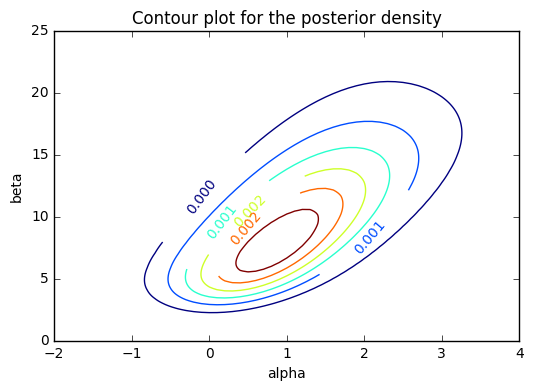

In [31]:
plt.figure()
CS = plt.contour(ALPHA, BETA, P)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Contour plot for the posterior density')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.xlim((-2,4))
plt.ylim((0,25))

we can now calculate the average alpha and beta distributions by averaging over the other direction

In [32]:
# average distributions
alpha_pro=np.mean(P,axis=0)
beta_pro=np.mean(P,axis=1)

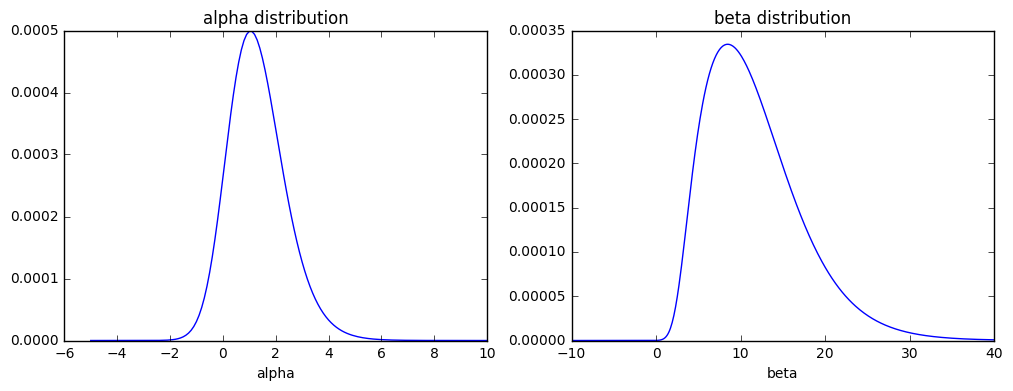

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(alpha,alpha_pro)
plt.xlabel('alpha')
plt.title('alpha distribution')
plt.subplot(1,2,2)
plt.plot(beta,beta_pro)
plt.xlabel('beta')
plt.title('beta distribution')

In this example we will employ a Gibbs sampler that we start with a random sample from the average alpha distribution.
We sampling using the inverse-cdf method that is described in Gelman's book. 

In [34]:
n=1000
# Starting point for Gibbs sampler is drawn from average alpha
alpha0=inv_cdf(alpha_pro,alpha)(np.random.random())
beta0=inv_cdf(p_posterior(alpha0,beta,dose,deaths,n_samples),beta)(np.random.random())

alpha_sampling=[alpha0]
beta_sampling=[beta0]

for i in range(n):
    alpha1=inv_cdf(p_posterior(alpha,beta_sampling[-1],dose,deaths,n_samples),alpha)(np.random.random())
    alpha_sampling.append(alpha1)
    beta1=inv_cdf(p_posterior(alpha_sampling[-1],beta,dose,deaths,n_samples),beta)(np.random.random())
    beta_sampling.append(beta1)

beta_sampling=np.array(beta_sampling)
alpha_sampling=np.array(alpha_sampling)

ld50=-alpha_sampling/beta_sampling

lets look at the calculated LD50 distribution

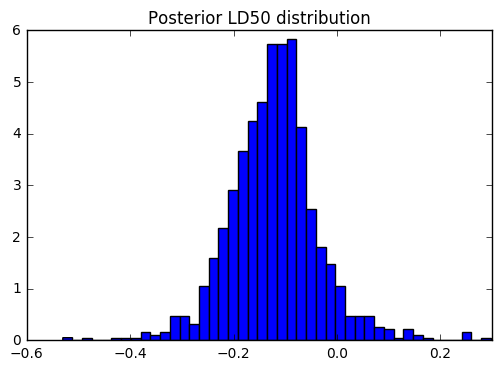

In [35]:
plt.figure()
plt.hist(ld50,bins='auto',normed=True)
plt.title('Posterior LD50 distribution')

In [36]:
print(np.percentile(ld50,[2.5,25,50,75,97.5]))

[-0.29258343 -0.17273716 -0.12136663 -0.07699568  0.06162208]


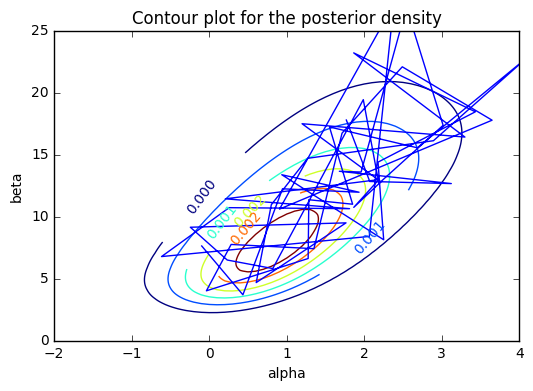

In [37]:
plt.figure()
CS = plt.contour(ALPHA, BETA, P)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Contour plot for the posterior density')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.xlim((-2,4))
plt.ylim((0,25))
plt.plot(alpha_sampling[:50], beta_sampling[:50])